In [1]:
import numpy as np 
import matplotlib.pyplot as plt # 図の作成環境のロード
from matplotlib import cm # カラーマップ
from tqdm import tqdm # プログレスバーを表示
import time # 計算時間計測プロファイリング用
#
# 図のテキストにLaTeXを使う (Tex環境が必要かも)
# plt.rcParams['text.usetex'] = True
#
# numbaで高速化
from numba import double
from numba import jit 
# 
from IPython.display import clear_output

In [2]:
# parameters 
# computational domain
Lx=0.1e0
Ly=Lx
# wall velocity
Uwall=0.01
# fluid property
nu=1.e-5 # kinematic viscosity (=mu/rho)
# rho=1.e3 # density
# thermal property 
itemp = 1
if itemp==1:
    Tbc_H = 1.0
    Tbc_L = 0.0
    #Tref=Tbc_H - Tbc_L # the code assume that Tref=1.0 
    kappa=1.e-6
    gbeta =1.e-3 # gravity coeff, thermal expansion rate

# nondimensional time (in L/Uwall)
endT=20

# mesh girds
Nx=41
Ny=43

# for dt
CFL=0.5
CFLv=0.8
if itemp==1:
    CFLk=CFLv

# for solver
accel = 1.925e0
err_tol = 1.e-6
tiny = 1.e-20

In [6]:
# set grid 
dx=Lx/np.float64(Nx-1)
dy=Ly/np.float64(Ny-1)

# mesh information (grid)
x=np.array(np.zeros(Nx+2),dtype=np.float64)
y=np.array(np.zeros(Ny+2),dtype=np.float64)
# cell centre position
xc=np.array(np.zeros(Nx+1),dtype=np.float64)
yc=np.array(np.zeros(Ny+1),dtype=np.float64)

# set uniform mesh
x[0]=-dx
for i in range(1,Nx+2):
    x[i]=x[i-1]+dx; # raw grid
    xc[i-1]=0.5*(x[i-1]+x[i])/Lx # scaled axis of cell centre

y[0]=-dy
for i in range(1,Ny+2):
    y[i]=y[i-1]+dy; # raw grid 
    yc[i-1]=0.5*(y[i-1]+y[i])/Lx # scaled axis of cell centre

x2d, y2d = np.meshgrid(x,y)    
    
if Uwall != 0.0:
    Uref = Uwall
elif gbeta != 0.0:
    Uref = np.sqrt(gbeta*Lx) # Lx is added, 2021/07/09
else:
    Uref = nu/Lx
    
dt = min(CFL*dx/Uref, CFLv*dx*dx/nu)
if itemp==1:
    dt = min(dt, CFLk*dx*dx/kappa, CFL*dy/np.sqrt(gbeta*Lx)) # Lx is added, 2021/07/09

Nt = int(endT*Lx/Uref/dt)

dx2=(dx*dx) 
dy2=(dy*dy) # bug fixed 2021/06/28 


In [7]:
# variables 
u=np.zeros([Ny+1, Nx+2],dtype=np.float64)
v=np.zeros([Ny+2, Nx+1],dtype=np.float64)
p=np.zeros([Ny+1, Nx+1],dtype=np.float64)

uaux=np.zeros([Ny+1, Nx+2],dtype=np.float64)
vaux=np.zeros([Ny+2, Nx+1],dtype=np.float64)
dive=np.zeros([Ny+1, Nx+1],dtype=np.float64)
if itemp==1:
    T      =np.zeros([Ny+1, Nx+1],dtype=np.float64)
    Taux=np.zeros([Ny+1, Nx+1],dtype=np.float64)
    
# for plot the velocity on regular grid
#ur=np.array(np.zeros((Ny, Nx+2),dtype=np.float64))
#vr=np.array(np.zeros((Ny+2, Nx),dtype=np.float64))

In [8]:
# Fortran 配列から Namba配列にするには: (i,j) --> [j,i] に変更, 改行(&) --> バックスラッシュ (/)に変更
# 改行コード(/)のあとにスペースが有ると エラーが出る．
# 変数 2.d0 --> 2e0
# 
# numbaで反復計算を高速化
# ---------------------------------------------- #
@jit
def calc_aux_u(uaux,u,v):
    for jc in range(1, Ny):
        for i in range(1, Nx+1):
            visc = (u[jc, i-1]-2e0*u[jc,i]+u[jc, i+1])/dx2 \
                    +(u[jc-1, i]-2e0*u[jc,i]+u[jc+1, i])/dy2
            conv = (+( ( u[jc, i-1] + u[jc, i])/2e0 \
                              *(-u[jc, i-1]+u[jc, i])/dx ) \
                          +( ( u[jc, i]+u[jc, i+1])/2e0 \
                              *(-u[jc, i]+u[jc, i+1])/dx ) \
                         )/2e0 \
                        +(+( ( v[jc, i-1]+v[jc, i])/2e0 \
                               *(-u[jc-1,i]+u[jc, i])/dy ) \
                            +( ( v[jc+1, i-1] + v[jc+1,i])/2e0 \
                               *(-u[jc,i]+u[jc+1,i])/dy ) \
                         )/2e0
            uaux[jc,i] = u[jc,i] + dt*(-conv + nu*visc)
# ---------------------------------------------- #
@jit            
def calc_aux_v(vaux,u,v):
    for j in range(1, Ny+1):
        for ic in range(1, Nx):
            # 
            visc = (v[j-1, ic]-2e0*v[j, ic]+v[j+1, ic])/dy2 \
                    +(v[j, ic-1]-2e0*v[j, ic]+v[j, ic+1])/dx2
            conv = (+( ( u[j-1, ic]+u[j, ic])/2e0 \
                              *(-v[j, ic-1]+v[j, ic])/dx ) \
                          +( ( u[j-1, ic+1]+u[j, ic+1])/2e0 \
                              *(-v[j, ic]+v[j, ic+1])/dx ) \
                         )/2e0 \
                       +(+( ( v[j-1, ic]+v[j, ic])/2e0 \
                              *(-v[j-1, ic]+v[j, ic])/dy ) \
                           +( ( v[j, ic]+v[j+1, ic])/2e0 \
                              *(-v[j, ic]+v[j+1, ic])/dy ) \
                         )/2e0
            vaux[j, ic] = v[j, ic] + dt*(-conv + nu*visc) 
# ---------------------------------------------- #
@jit
def set_bc_v(v):
    # left and right walls (embedded)
    for j in range(0,Ny+2):    
        v[j,0] = -v[j,1]
        v[j,Nx]= -v[j,Nx-1]

    # bottom and top walls (on walls)
    for ic in range(0,Nx+1):
        v[1,ic]  =0.e0
        v[Ny,ic] =0.e0
        v[0,ic]  = -v[2,ic]
        v[Ny+1,ic] = -v[Ny-1,ic]
# ---------------------------------------------- #
@jit
def set_bc_u(u):
    # left and right walls
    for jc in range(0,Ny+1): # bug fixed 2021/07/10
        u[jc,1] =0.e0; 
        u[jc,Nx]=0.e0
        u[jc,0] = -u[jc,2] # left imaginary cell
        u[jc,Nx+1] = -u[jc,Nx-1] # right imaginary cell

    # bottom and top walls (embedded)
    for i in range(0,Nx+2):
        u[0,i] = -u[1,i]  # bottom wall (uc=0)
        u[Ny,i] = -u[Ny-1,i]+2.e0*Uwall # moving wall (uc=Uwall)
# ---------------------------------------------- #
@jit
def divergence(div,u,v):
    for jc in range(1,Ny):
        for ic in range(1,Nx):
            div[jc,ic] = ( (-u[jc,ic] + u[jc, ic+1])/dx \
                       +(-v[jc,ic] + v[jc+1, ic])/dy \
                      )/dt
# ---------------------------------------------- #
@jit
def calcP(p,div):
    err_n=0.0
    err_d=0.0
    for jc in range(1,Ny):
        for ic in range(1,Nx):
            # bug fixed 2021/06/28
            d_pres = (  dy2*(p[jc, ic-1] + p[jc, ic+1]) \
                             + dx2*(p[jc-1,ic] + p[jc+1,ic]) \
                           - (dx2*dy2 * div[jc,ic]) )/((dx2+dy2)*2e0) - p[jc,ic]
            p[jc,ic] = p[jc,ic] + accel*d_pres
            err_n = err_n + d_pres*d_pres
            err_d = err_d + p[jc,ic]*p[jc,ic]
    set_bc_pressure(p)
    if err_d < tiny:
        err_d = 1e0
    err_r = np.sqrt(err_n/err_d)
    return err_r
# ---------------------------------------------- #
@jit
def set_bc_pressure(p):
    # p[1,1]=0.e0
    for ic in range(1,Nx):
        p[0,ic] = p[1,ic]
        p[Ny,ic]= p[Ny-1,ic]
    for jc in range(1,Ny):
        p[jc,0]=p[jc,1]
        p[jc,Nx]=p[jc,Nx-1]
# ---------------------------------------------- #            
@jit 
def correct_u(u, uaux, p):
    for jc in range(1, Ny):
        for i in range(1, Nx+1):
            u[jc, i] = uaux[jc, i] - dt*(-p[jc, i-1] + p[jc, i])/dx
# ---------------------------------------------- #
@jit
def correct_v(v, vaux, p):
    for j in range(1, Ny+1):
        for ic in range(1, Nx):
            v[j, ic] = vaux[j, ic] - dt*(-p[j-1, ic] + p[j, ic])/dy
# ---------------------------------------------- #
@jit
def calc_temp(T,Taux,u,v):
    for jc in range(1,Ny):
        for ic in range(1,Nx):
            tdiff = (Taux[jc, ic-1]-2e0*Taux[jc,ic]+Taux[jc, ic+1])/dx2 \
                    +(Taux[jc-1, ic]-2e0*Taux[jc,ic]+Taux[jc+1, ic])/dy2
            tconv_x = ( ( u[jc, ic]*(-T[jc, ic-1]+T[jc, ic])/dx ) \
                               +( u[jc, ic+1]*(-T[jc, ic]+T[jc, ic+1])/dx ) \
                               )/2e0             
            tconv_y = (  (v[jc, ic]*(-T[jc-1,ic]+T[jc, ic])/dy ) \
                                 +(v[jc+1,ic]*(-T[jc,ic]+T[jc+1,ic])/dy ) \
                                )/2e0
            T[jc,ic]= Taux[jc,ic] - dt*(tconv_x + tconv_y) + dt*kappa*tdiff 
@jit
def set_bc_temp(T, Tbc_H, Tbc_L):
    for jc in range(1, Ny):
        T[jc, 0] = 2.0*Tbc_H - T[jc, 1]         # left imaginary cell
        T[jc, Nx] = 2.0*Tbc_L - T[jc, Nx-1] # right imaginary cell

    # bottom and top walls
    for ic in range(1, Nx):
        T[0, ic] = T[1, ic]         # bottom wall, adiabatic 
        T[Ny, ic] = T[Ny-1, ic] # moving wall, adiabatic
# ---------------------------------------------- #
@jit
def add_grav(vaux,T):
    for j in range(1, Ny):
        for ic in range(1, Nx):
            vaux[j, ic] = vaux[j, ic] + dt*gbeta*((T[j,ic] + T[j+1,ic])/2.0 )

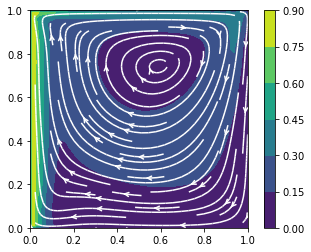

100%|██████████| 1680/1680 [01:53<00:00, 14.83it/s]

time elapsed:113.40905094146729 sec., nstep=1679


In [9]:
# ---------------------------------------------- #
time_ini=time.time()
ifield=0; 
for itr in tqdm(range(0,Nt)):
    t0=time.time()
    calc_aux_u(uaux, u, v)
    set_bc_u(uaux)
    calc_aux_v(vaux, u, v)
    if itemp==1:
        add_grav(vaux, T)
    set_bc_v(vaux)
    divergence(dive, uaux, vaux)
    
    # solving phi
    err_r=1.e0
    itr_SOR=0
    while err_r > err_tol:
        itr_SOR += 1
        err_r=calcP(p, dive)
        if itr < 10: 
            if itr_SOR >1000: 
                break
        elif itr < 20: 
            if itr_SOR >5000: 
                break        
        elif itr < 30: 
            if itr_SOR >10000: 
                break
    if np.isnan(err_r)==1:
        print('NaN: at itr='+str(itr)+', itr(SOR)='+str(itr_SOR))
        break
    if np.mod(itr,100)==0:
        ifield += 1
        print('istep='+str(itr)+':  calcP: itr (SOR)='+str(itr_SOR)+', error='+str(err_r))
        filename='field_'
        #fig.savefig(filename+'%04d'%ifield+'.png')
        
    correct_u(u, uaux, p)
    set_bc_u(u)
    correct_v(v, vaux, p)
    set_bc_v(v)
    if itemp==1:
        Taux = T.copy()
        set_bc_temp(Taux,Tbc_H,Tbc_L)
        calc_temp(T,Taux,u,v)

    if np.mod(itr,100)==0:
        clear_output(True)
        fig, ax = plt.subplots()
        if itemp==1:
            # plot temperature 
            tcf = ax.contourf(xc, yc, T)
        else:
            tcf = ax.contourf(xc, yc, p)
        fig.colorbar(tcf)
        # rough interpolation of velocities
        uc=0.5*(u[:,:-1]+u[:,1:])/Uref # interpolate at the regular grid with scaling
        vc=0.5*(v[:-1,:]+v[1:,:])/Uref # interpolate at the regular grid with scaling
        ax.streamplot(xc,yc,uc,vc,color='w',density=1,integration_direction='backward',arrowstyle="->")
        ax.set_aspect('equal')
        plt.xlim(0, 1); plt.ylim(0, 1);
        plt.show()
    
    t1=time.time()
    #print('time elapsed:'+str(t1-t0)+' sec.,')
print('time elapsed:'+str(t1-time_ini)+' sec.,'+' nstep='+str(itr))

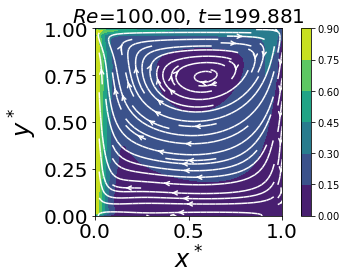

In [10]:
# interpolate
uc=0.5*(u[:,:-1]+u[:,1:])/Uref # interpolate at the cell centre with scaling
vc=0.5*(v[:-1,:]+v[:1,:])/Uref # interpolate at the cell centre with scaling

# Controlling the starting points of the streamlines
#seed_points = np.array([x2d[::4,::4].reshape(121), y2d[::4,::4].reshape(121)])
# 結果の図示
# plot streamlines and pressure field
fig, ax = plt.subplots()
if itemp==1:
    tcf = ax.contourf(xc, yc, T)
else:
    tcf = ax.contourf(xc, yc, p)
fig.colorbar(tcf)

#ax.streamplot(x2d,y2d,ur,vr,color='w',integration_direction='both',arrowsize=1.5,arrowstyle="->",
#               minlength=0.2,maxlength=0.8,start_points=seed_points.T)

ax.streamplot(xc,yc,uc,vc,color='w',density=1,integration_direction='backward',arrowstyle="->")
ax.set_aspect('equal')
plt.xlim(0, 1); plt.ylim(0, 1)
ax.set_title("$Re$={0:.2f}".format(Uwall*Ly/nu)+", $t$={0:.3f}".format(itr*dt),fontsize=20)
ax.set_xlabel('$x^*$',fontsize=24)
ax.set_ylabel("$y^*$",fontsize=24)
ax.tick_params(labelsize=20)
ax.set_aspect('equal')
plt.tight_layout()

plt.show()

In [16]:
###########################################################
# save the steady solution of FWD solver
u0 = -u; v0 = -v; p0 = p; T0 = T;

# adjoint variables 
ua=np.zeros([Ny+1, Nx+2],dtype=np.float64)
va=np.zeros([Ny+2, Nx+1],dtype=np.float64)
pa=np.zeros([Ny+1, Nx+1],dtype=np.float64)
Ta=np.zeros([Ny+1, Nx+1],dtype=np.float64)

iTag=np.zeros([Ny+1, Nx+1],dtype=np.int64)
iTag[20:25,20:25]=1
A_tar=np.sum(iTag)*dx*dy

In [13]:
@jit
def calc_aux_ua(uaux,u0,v0,ua,va):
    for jc in range(1, Ny):
        for i in range(1, Nx+1):
            visc = (ua[jc, i-1]-2e0*ua[jc,i]+ua[jc, i+1])/dx2 \
                    +(ua[jc-1, i]-2e0*ua[jc,i]+ua[jc+1, i])/dy2
            conva = (+( ( u0[jc, i-1] + u0[jc, i])/2e0 \
                              *(-ua[jc, i-1]+ua[jc, i])/dx ) \
                          +( ( u0[jc, i]+u0[jc, i+1])/2e0 \
                              *(-ua[jc, i]+ua[jc, i+1])/dx ) \
                         )    \
                        +(+( ( v0[jc, i-1]+v0[jc, i])/2e0 \
                               *(-ua[jc-1,i]+ua[jc, i])/dy ) \
                            +( ( v0[jc+1, i-1] + v0[jc+1,i])/2e0 \
                               *(-ua[jc,i]+ua[jc+1,i])/dy ) \
                         )/2e0
            fua = ( (v0[jc,  i-1]+v0[jc,  i])/2e0 * (-va[jc,  i-1]+va[jc,  i])/dx \
                   +(v0[jc+1,i-1]+v0[jc+1,i])/2e0 * (-va[jc+1,i-1]+va[jc+1,i])/dx \
                   )/2e0
            uaux[jc,i] = ua[jc,i] + dt*(-conva - fua + nu*visc )
# ---------------------------------------------- #
@jit            
def calc_aux_va(vaux,u0,v0,ua,va):
    for j in range(1, Ny+1):
        for ic in range(1, Nx):
            # 
            visc = (va[j-1, ic]-2e0*va[j, ic]+va[j+1, ic])/dy2 \
                    +(va[j, ic-1]-2e0*va[j, ic]+va[j, ic+1])/dx2
            conva = (+( ( u0[j-1, ic]+u0[j, ic])/2e0 \
                              *(-va[j, ic-1]+va[j, ic])/dx ) \
                          +( ( u0[j-1, ic+1]+u0[j, ic+1])/2e0 \
                              *(-va[j, ic]+va[j, ic+1])/dx ) \
                         )/2e0 \
                       +(+( ( v0[j-1, ic]+v0[j, ic])/2e0 \
                              *(-va[j-1, ic]+va[j, ic])/dy ) \
                           +( ( v0[j, ic]+v0[j+1, ic])/2e0 \
                              *(-va[j, ic]+va[j+1, ic])/dy ) \
                         )
            fva = ( (u0[j-1,ic  ]+u0[j,ic  ])/2e0 * (-ua[j-1,ic  ]+ua[j,ic  ])/dy \
                   +(u0[j-1,ic+1]+u0[j,ic+1])/2e0 * (-ua[j-1,ic+1]+ua[j,ic+1])/dy \
                   )/2e0
            vaux[j, ic] = va[j, ic] + dt*(-conva - fva + nu*visc) 
# ---------------------------------------------- #
@jit
def set_bc_va(va):
    # left and right walls (embedded)
    for j in range(0,Ny+2):    
        va[j,0] = -va[j,1]
        va[j,Nx]= -va[j,Nx-1]

    # bottom and top walls (on walls)
    for ic in range(0,Nx+1):
        va[1,ic]  =0.e0
        va[Ny,ic] =0.e0
        va[0,ic]  = -va[2,ic]
        va[Ny+1,ic] = -va[Ny-1,ic]
# ---------------------------------------------- #
@jit
def set_bc_ua(ua):
    # left and right walls
    for jc in range(0,Ny+1):
        ua[jc,1] =0.e0; 
        ua[jc,Nx]=0.e0
        ua[jc,0] = -ua[jc,2] # left imaginary cell
        ua[jc,Nx+1] = -ua[jc,Nx-1] # right imaginary cell

    # bottom and top walls (embedded)
    for i in range(0,Nx+2):
        ua[0,i] = -ua[1,i]  # bottom wall (uc=0)
        ua[Ny,i] = -ua[Ny-1,i] #+2.e0*Uwall # moving wall (uc=Uwall)
# ---------------------------------------------- #
@jit
def calc_tempa(Ta,Taux,u0,v0):
    for jc in range(1,Ny):
        for ic in range(1,Nx):
            tdiff = (Taux[jc, ic-1]-2e0*Taux[jc,ic]+Taux[jc, ic+1])/dx2 \
                    +(Taux[jc-1, ic]-2e0*Taux[jc,ic]+Taux[jc+1, ic])/dy2
            tconva_x = ( (u0[jc, ic]*(-Ta[jc, ic-1]+Ta[jc, ic])/dx ) \
                               +( u0[jc, ic+1]*(-Ta[jc, ic]+Ta[jc, ic+1])/dx ) \
                               )/2e0             
            tconva_y = ( (v0[jc, ic]*(-Ta[jc-1,ic]+Ta[jc, ic])/dy ) \
                                 +(v0[jc+1,ic]*(-Ta[jc,ic]+Ta[jc+1,ic])/dy ) \
                               )/2e0
            Ta[jc,ic]= Taux[jc,ic] -dt*(tconva_x + tconva_y) + dt*kappa*tdiff 
# ---------------------------------------------- #
@jit
def add_divTa(uaux,vaux,T0,Ta):
    for jc in range(1, Ny):
        for i in range(1, Nx):
            uaux[jc, i] = uaux[jc, i] + dt*((T0[jc,i] + T0[jc,i+1])/2.0)*(-Ta[jc,i] + Ta[jc,i+1])/dx
    for j in range(1, Ny):
        for ic in range(1, Nx):
            vaux[j, ic] = vaux[j, ic] + dt*((T0[j,ic] + T0[j+1,ic])/2.0)*(-Ta[j,ic] + Ta[j+1,ic])/dy
@jit
def add_grava(va,Ta):
    for jc in range(1, Ny):
        for ic in range(1, Nx):
            Ta[jc, ic] += dt*gbeta*(va[jc, ic] + va[jc+1, ic])/2e0
@jit
def set_bc_tempa(Ta, Tabc_H, Tabc_L):
    for jc in range(1, Ny):
        Ta[jc, 0] = 2.0*Tabc_H - Ta[jc, 1]         # left imaginary cell
        Ta[jc, Nx] = 2.0*Tabc_L - Ta[jc, Nx-1] # right imaginary cell

    # bottom and top walls
    for ic in range(1, Nx):
        Ta[0, ic] = 0e0 - Ta[1, ic]         # bottom wall, adiabatic 
        Ta[Ny, ic] = 0e0 - Ta[Ny-1, ic] # moving wall, adiabatic
            

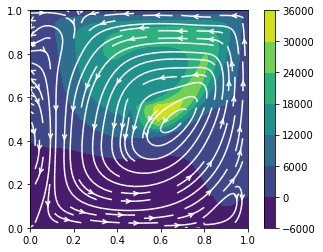

100%|██████████| 1680/1680 [05:16<00:00,  5.31it/s]

time elapsed:316.542603969574 sec., nstep=1679


In [18]:
# ---------------------------------------------- #
time_ini=time.time()
ifield=0; 
for itr in tqdm(range(0,Nt)):
    t0=time.time()
    calc_aux_ua(uaux,u0,v0,ua,va)
    set_bc_ua(uaux)
    calc_aux_va(vaux,u0,v0,ua,va)
    set_bc_va(vaux)
    if itemp==1:
        add_divTa(uaux,vaux,T0,Ta)
    # here, set target area and objective functional for u (and p)
    
        
    divergence(dive, uaux, vaux)
    
    # solving phi
    err_r=1.e0
    itr_SOR=0
    while err_r > err_tol:
        itr_SOR += 1
        err_r=calcP(pa, dive)
        if itr < 10: 
            if itr_SOR >1000: 
                break
        elif itr < 20: 
            if itr_SOR >5000: 
                break        
        elif itr < 30: 
            if itr_SOR >10000: 
                break
    if np.isnan(err_r)==1:
        print('NaN: at itr='+str(itr)+', itr(SOR)='+str(itr_SOR))
        break
    if np.mod(itr,100)==0:
        ifield += 1
        print('istep='+str(itr)+':  calcP: itr (SOR)='+str(itr_SOR)+', error='+str(err_r))
        filename='field_'
        #fig.savefig(filename+'%04d'%ifield+'.png')
        
    correct_u(ua, uaux, pa)
    set_bc_ua(ua)
    correct_v(va, vaux, pa)
    set_bc_va(va)
    
    if itemp==1:
        Taux = Ta.copy()
        set_bc_tempa(Taux,0e0,0e0)
        calc_tempa(Ta,Taux,u0,v0)
        add_grava(va,Ta)
        # here, set target area and objective functional for T
        Ta += dt*(-2e0*(T - 0.5e0)*iTag)/A_tar
        
        
    if np.mod(itr,100)==0:
        clear_output(True)
        fig, ax = plt.subplots()
        if itemp==1:
            # plot temperature 
            tcf = ax.contourf(xc, yc, Ta)
        else:
            tcf = ax.contourf(xc, yc, pa)
        fig.colorbar(tcf)
        # rough interpolation of velocities
        uac=0.5*(ua[:,:-1]+ua[:,1:])/Uref # interpolate at the regular grid with scaling
        vac=0.5*(va[:-1,:]+va[1:,:])/Uref # interpolate at the regular grid with scaling
        ax.streamplot(xc,yc,uac,vac,color='w',density=1,integration_direction='backward',arrowstyle="->")
        ax.set_aspect('equal')
        plt.xlim(0, 1); plt.ylim(0, 1);
        plt.show()
    
    t1=time.time()
    #print('time elapsed:'+str(t1-t0)+' sec.,')
print('time elapsed:'+str(t1-time_ini)+' sec.,'+' nstep='+str(itr))

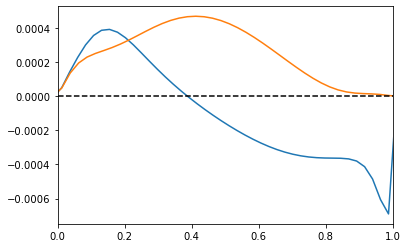

In [19]:
qs_x = -kappa*(-Ta[:,:-1]+Ta[:,1:])
qs_y = -kappa*(-Ta[:-1,:]+Ta[1:,:])
plt.plot(yc,qs_x[:,0]) # Sensitivity on the left wall
plt.plot(xc,qs_y[0,:]) # Sensitivity on the bottom wall
plt.plot([0,1],[0,0],'k--') # Sensitivity on the bottom wall
plt.xlim(0,1);